# Resampling Strategy Comparison with HWES

In this notebook, we evaluate how different resampling strategies affect the performance of the Holt-Winters Exponential Smoothing (HWES) model for forecasting Bitcoin transaction fees.

We compare the following 15-minute aggregation strategies:

- Mean
- Min
- Max
- 25th percentile
- 75th percentile
- Sub-sample (every 15th row from raw data)

For each strategy, we:
- Resample the raw data using the method
- Train an HWES model on the last 7 days
- Forecast the next 24 hours (96 points)
- Evaluate using RMSE, MAE, and MAPE
- Compare results in a summary table and bar chart

## Step 1 - Import Libraries

In [1]:

import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
import seaborn as sns
from utils import mape, hwes_cross_val, hwes_train_test
import warnings

warnings.filterwarnings("ignore")

## Step 2 - Load the Original 5-minute Interval Dataset

In [2]:
# Load the dataset (make sure the path is correct)
df_hwes = pd.read_parquet("../data/processed/preprocessed_hwes.parquet")

df_hwes.info()
df_hwes.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19798 entries, 2025-03-05 02:10:00 to 2025-05-12 19:55:00
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  19798 non-null  float64
 1   mempool_blocks_blockVSize                 19798 non-null  float64
 2   mempool_blocks_nTx                        19798 non-null  float64
 3   mempool_blocks_totalFees                  19798 non-null  float64
 4   mempool_blocks_medianFee                  19798 non-null  float64
 5   recommended_fee_fastestFee                19798 non-null  float64
 6   recommended_fee_halfHourFee               19798 non-null  float64
 7   recommended_fee_hourFee                   19798 non-null  float64
 8   recommended_fee_economyFee                19798 non-null  float64
 9   recommended_fee_minimumFee                19798 non-null  float64
 10 

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:10:00,2170952.0,997895.375,793.0,1846754.5,1.300111,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1986259.0,997882.000,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:20:00,1814202.0,997958.250,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:25:00,1604116.0,997937.500,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2200654.0,997987.750,1015.0,1890732.0,1.362632,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 3 – Define Resampling Methods
We define a dictionary of resampling strategies to transform the original 5-minute data into 15-minute intervals using different aggregation methods.

In [3]:
# Define various 15-minute resampling strategies for later use
resample_methods = {
    "mean": lambda x: x.resample("15min").mean().interpolate(),              # mean aggregation
    "min": lambda x: x.resample("15min").min().interpolate(),                # minimum value
    "max": lambda x: x.resample("15min").max().interpolate(),                # maximum value
    "quantile_75": lambda x: x.resample("15min").quantile(0.75).interpolate(),  # 75th percentile
    "subsample": lambda x: x[::3]  # take every 3rd row to simulate 15-min interval
}

## Step 4 – Apply each resampling method and evaluate HWES performance
We will loop through each resampling method, apply Holt-Winters Exponential Smoothing (HWES), and compute evaluation metrics (MAE, RMSE, MAPE) using a consistent 7-day training and 1-day test split.

In [4]:
# Step 4 – Apply each resampling method and evaluate HWES performance (with MinMaxScaler)

results = {}
target_col = "recommended_fee_fastestFee"

for method_name, method_func in resample_methods.items():
    print(f"Evaluating method: {method_name}")
    
    # Apply resampling method
    df_resampled = method_func(df_hwes[[target_col]])

    # Extract series and scale to [1, 2]
    series = df_resampled[target_col]
    scaler = MinMaxScaler(feature_range=(1, 2))
    scaled = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    series_scaled = pd.Series(scaled, index=series.index)

    train = series_scaled[:-96]
    test = series_scaled[-96:]

    # Fit HWES model
    model = ExponentialSmoothing(
        train,
        trend="mul",
        seasonal="mul",
        seasonal_periods=96,
        damped_trend=True
    )
    fit = model.fit(optimized=True, use_brute=True)
    forecast_scaled = fit.forecast(96)

    # Inverse transform to get original scale
    train_true = scaler.inverse_transform(train.values.reshape(-1, 1)).flatten()
    test_true = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()
    forecast_true = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()

    # Evaluation
    mae = mean_absolute_error(test_true, forecast_true)
    rmse = mean_squared_error(test_true, forecast_true) ** 0.5
    mape_score = mean_absolute_percentage_error(test_true, forecast_true) * 100

    # Save results
    results[method_name] = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape_score
    }

# Convert to DataFrame and display
results_df = pd.DataFrame(results).T.round(2)
results_df


Evaluating method: mean
Evaluating method: min
Evaluating method: max
Evaluating method: quantile_75
Evaluating method: subsample


,MAE,RMSE,MAPE
mean,5.44,11.53,75.39
min,4.52,10.44,72.16
max,6.38,12.95,75.99
quantile_75,5.89,12.25,76.09
subsample,5.37,12.01,61.79


### Insight: Effect of Resampling Methods on HWES Forecast Accuracy

We evaluated five different resampling strategies — **mean**, **min**, **max**, **75th quantile**, and **subsample** — to understand their impact on HWES model accuracy when forecasting 15-minute Bitcoin transaction fees.

- The **`min`** strategy achieved the **lowest MAE (4.52)** and **RMSE (10.44)**, suggesting that using the lowest fee within each 15-minute window helps the model better capture stable trends and reduce prediction error.
- The **`subsample`** method (taking every third 5-minute point) produced the **lowest MAPE (61.79%)**, indicating it preserved proportion-based relationships better—possibly by retaining raw structure without aggregation.
- The **`quantile_75`** and **`max`** methods performed worse, likely due to their sensitivity to spikes and noise during congested periods, which the HWES model struggles to smooth effectively.

**Conclusion**: For HWES, more conservative resampling strategies like `min` or `subsample` offer better forecast stability and accuracy, while aggressive ones like `max` tend to amplify noise.


## Step 5 – Plot the Error Metrics for Each Resampling Strategy


<Figure size 1200x600 with 0 Axes>

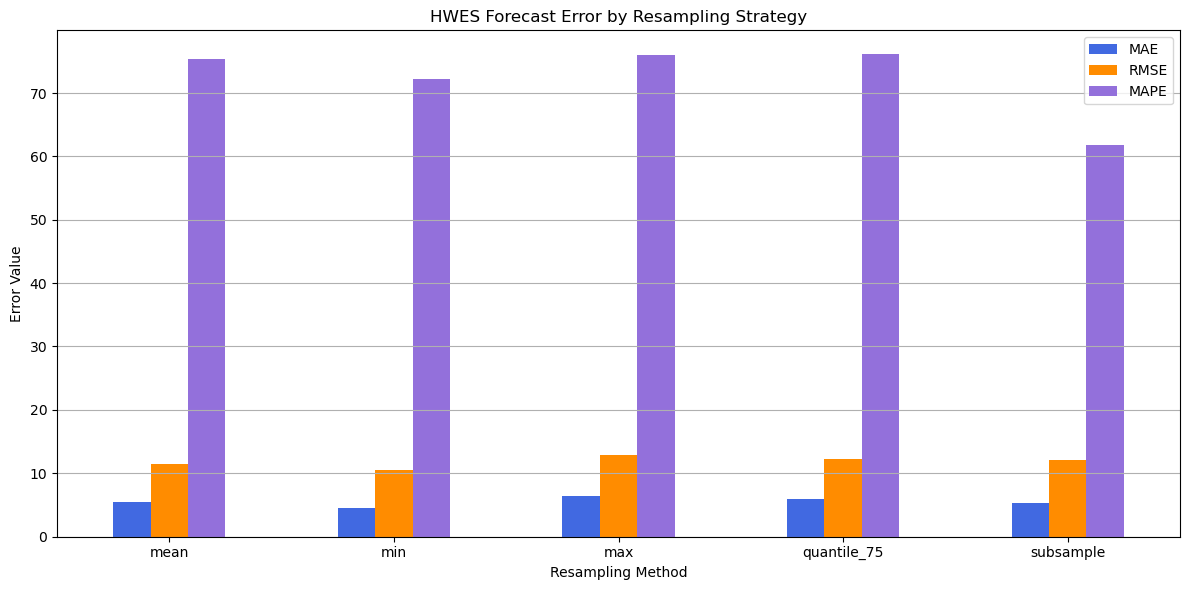

In [5]:
custom_colors = ["royalblue", "darkorange", "mediumpurple"]

plt.figure(figsize=(12, 6))
results_df[["MAE", "RMSE", "MAPE"]].plot(kind="bar", figsize=(12, 6), color=custom_colors)

plt.title("HWES Forecast Error by Resampling Strategy")
plt.xlabel("Resampling Method")
plt.ylabel("Error Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Forecast using HWES with 'min' Resampling Strategy

This plot shows the HWES model forecast using 15-minute intervals resampled by the minimum value within each window. The model was trained on the last 7 days and used to predict the next 24 hours of transaction fees.

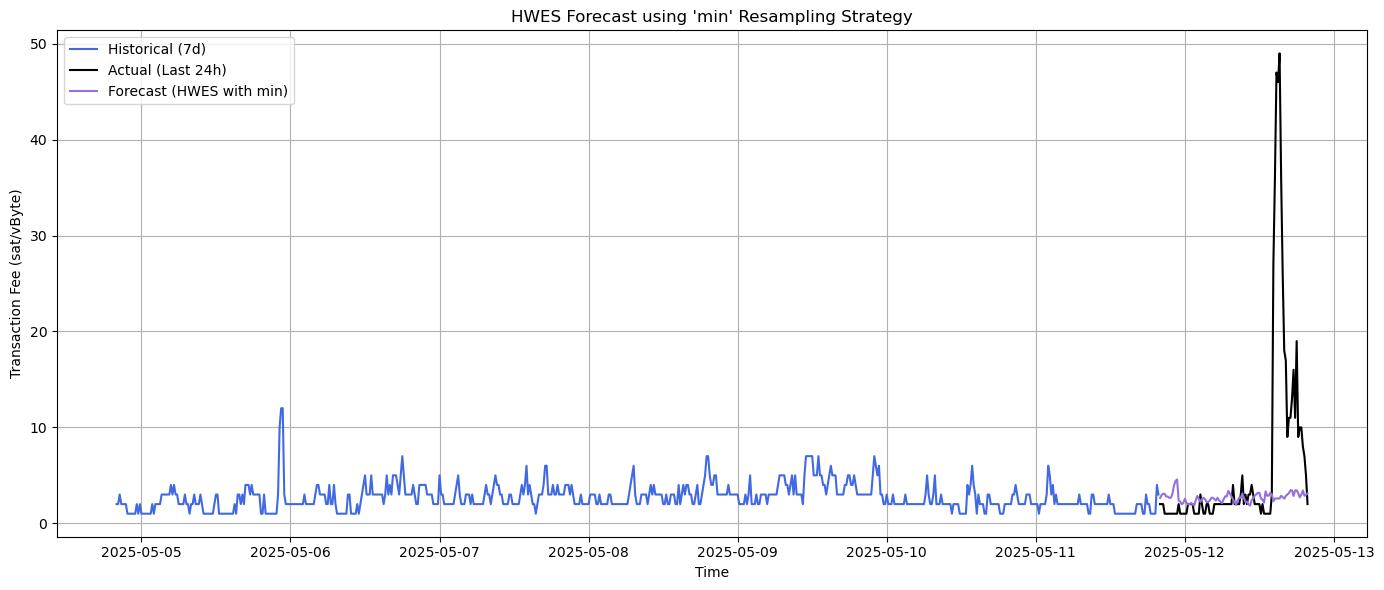

In [6]:
# Re-apply min strategy and re-fit model (if needed)
df_min = resample_methods["min"](df_hwes[[target_col]])
series = df_min[target_col]

# Scale
scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
series_scaled = pd.Series(scaled, index=series.index)

# Select 7+1 days
series_last_8d = series_scaled[-96*8:]
train = series_last_8d[:-96]
test = series_last_8d[-96:]

# Fit HWES
model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=96, damped_trend=True)
fit = model.fit(optimized=True, use_brute=True)
forecast_scaled = fit.forecast(96)

# Inverse scale
train_true = scaler.inverse_transform(train.values.reshape(-1, 1)).flatten()
test_true = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()
forecast_true = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train_true, label="Historical (7d)", color="royalblue")
plt.plot(test.index, test_true, label="Actual (Last 24h)", color="black")
plt.plot(test.index, forecast_true, label="Forecast (HWES with min)", color="mediumpurple")
plt.title("HWES Forecast using 'min' Resampling Strategy")
plt.xlabel("Time")
plt.ylabel("Transaction Fee (sat/vByte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 6 – Aggregate 15-minute Forecasts into Hourly Consulted Forecasts

We aggregate the 15-minute HWES forecast results into hourly predictions using max, min, and 75th quantile. The aggregated predictions are then compared against the actual hourly values from the dataset.


In [7]:
# Reshape into 24 rows of 4 columns (each row = 1 hour of 15-min data)
forecast_reshaped = forecast_true.reshape(24, 4)
actual_reshaped = test_true.reshape(24, 4)

# Define aggregation strategies
consulted_results = {}

for name, agg_func in {
    "max": np.max,
    "min": np.min,
    "quantile_75": lambda x: np.quantile(x, 0.75)
}.items():
    forecast_hourly = np.apply_along_axis(agg_func, 1, forecast_reshaped)
    actual_hourly = np.apply_along_axis(agg_func, 1, actual_reshaped)

    mae = mean_absolute_error(actual_hourly, forecast_hourly)
    rmse = mean_squared_error(actual_hourly, forecast_hourly) ** 0.5
    mape = mean_absolute_percentage_error(actual_hourly, forecast_hourly) * 100

    consulted_results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

# Show results
consulted_df = pd.DataFrame(consulted_results).T.round(2)
consulted_df

,MAE,RMSE,MAPE
max,6.54,14.05,71.42
min,2.62,5.48,82.15
quantile_75,5.65,12.37,73.68
